#### Library and data imports

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('complex9_gn8.csv')

features = data.iloc[:, :-1]  # All columns except the last one (the coords)
true_labels = data.iloc[:, -1].astype(int)  # Last column as ground truth (the class variable)

#### k-means Cluster Generation

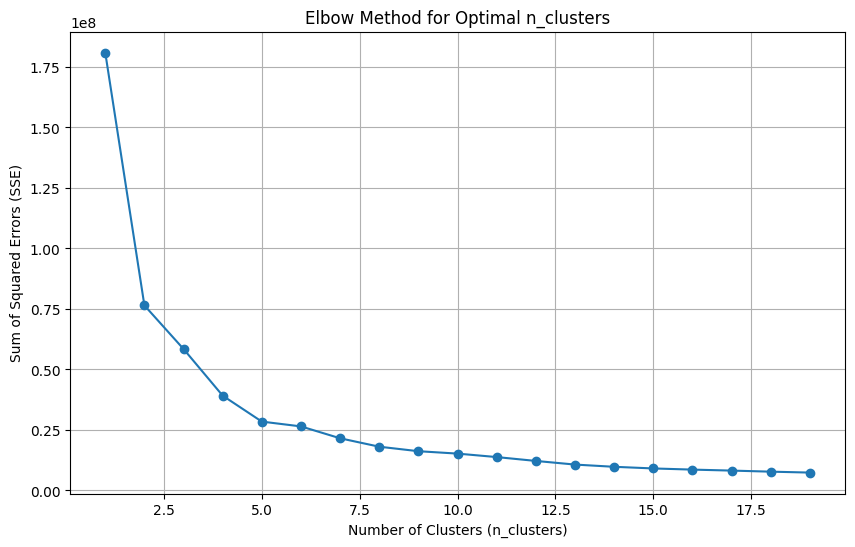

In [73]:
"""using a range of n_cluster nums and their  resulting SSE vals to find a good num_clusters value"""
# Define the range of cluster numbers to test
n_clusters_range = range(1, 20)
# Initialize a list to store the SSE values for each n_clusters
sse_values = []
# Calculate SSE for each value of n_clusters
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features)
    sse = kmeans.inertia_  # Inertia is the SSE for the K-means clustering
    sse_values.append(sse)
# Plot the SSE values against the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, sse_values, marker='o')
plt.xlabel("Number of Clusters (n_clusters)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for Optimal n_clusters")
plt.grid(True)
plt.show()


# Apply K-means clustering (example with k=3 clusters)
# from SSE plot, n_cluster val of 6-13 seems to be the best. 
    # Given the graph shown at the start of the task has 10 cluseters, I started with 10
    # Ended up using 12 b/c it resulted in highest purity
kmeans = KMeans(n_clusters=12, random_state=42)
kmeans_labels = kmeans.fit_predict(features)

#### DBScan Cluster Generation

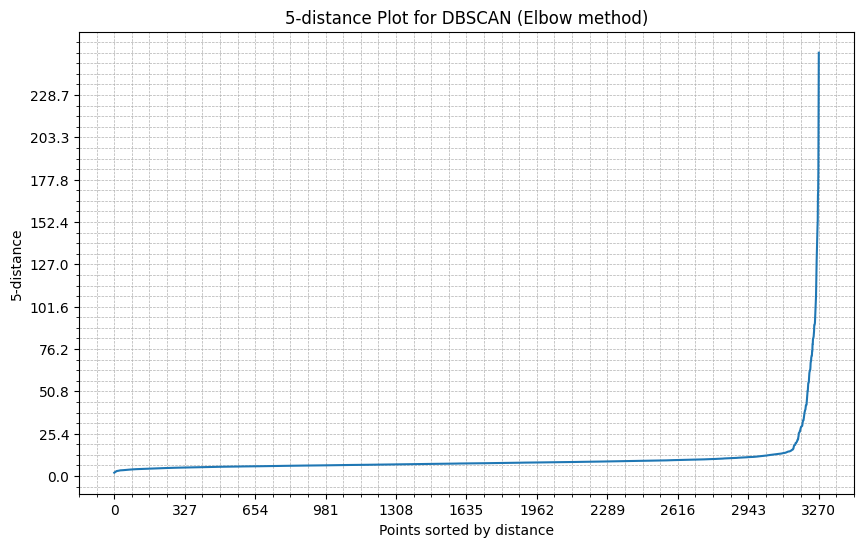

In [74]:
"""plotting k-distances to find a decent eps val for the dbscan clustering"""
min_samples = 5
# Fit NearestNeighbors to calculate k-distance
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(features)
distances, indices = neighbors_fit.kneighbors(features)
# Sort distances for the k-distance plot
k_distances = np.sort(distances[:, min_samples - 1])
# Plot the k-distance graph with enhanced grid and tick marks
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples}-distance")
plt.title(f"{min_samples}-distance Plot for DBSCAN (Elbow method)")
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.xticks(np.arange(0, len(k_distances), step=len(k_distances)//10))
plt.yticks(np.arange(0, max(k_distances), step=max(k_distances)/10))
plt.show()


# Apply DBSCAN clustering
# from k-dist plot got ideal eps of ~20
dbscan = DBSCAN(eps=20, min_samples=20)
dbscan_labels = dbscan.fit_predict(features)

#### Part A
Write  an  function1  purity(a,b,outliers=FALSE)  that  computes  the  purity  of  a clustering  result  based  on  an  apriori  given  set  of  class  lables,  where  a  gives  the assignment of objects in O to clusters, and b is the “ground truth”.   
 
Purity is defined as follows:  
- Let O be a dataset 
- X={C1,...,Ck} be a clustering of O with Ci ÍO (for i=1,...,k), C1È...ÈCk ÍO  and CiÇCj=Æ (for i¹ j)  
- PUR(X)= (number_of_majority_class_examples(X)/(total_number_examples_in_clusters(X))  

If the used clustering algorithm supports outliers, outliers should be ignored in purity computations; if you use R-clustering algorithms, you can assume that cluster 0 contains all the outliers, and clusters 1,2,...,k represent “true” clusters. If the parameter outliers is set to FALSE, the function just returns a floting point number of the observed purity, if parameter outliers is set to T the function returns a vector: (<purity>,<percentage_of_outliers>); e.g. if the function returns (0.98, 0.2) this would indicate that the purity is 98%, but 20% of the objects in dataset O have been classified as outliers. 

In [75]:

def purity(pred_labels, true_labels, outliers=False):
    clusters = np.unique(pred_labels)
    total_majority = 0
    total_points = len(pred_labels)

    for cluster in clusters:
        if outliers and cluster == 0:
            continue  # Ignore outliers in purity calculation if outliers=True
        mask = (pred_labels == cluster)
        cluster_labels = true_labels[mask]
        if len(cluster_labels) > 0:
            majority_class = np.bincount(cluster_labels).argmax()
            total_majority += np.sum(cluster_labels == majority_class)
    
    purity_score = total_majority / total_points

    if outliers:
        num_outliers = np.sum(pred_labels == 0)
        outlier_percentage = num_outliers / total_points
        return purity_score, outlier_percentage
    else:
        return purity_score

# Calculate purity for K-means
kmeans_purity = purity(kmeans_labels, true_labels, outliers=False)
print(f"K-means Purity: {kmeans_purity:.4f}\n")

""" 
Started with n_clusters=10, resulted in moderate purity (67%)
Ended with n_clusters=12, resulted in highest purity I could get (70%) - still moderate though
"""
"""
(GPT)Moderate Purity (0.6 - 0.8): Suggests that clusters contain some mixed classes but still have a majority class in each cluster. 
This may be acceptable depending on the complexity of the data, especially if achieving higher purity results in over-segmented or fragmented clusters.
"""

# Calculate purity for DBSCAN with outliers
dbscan_purity, dbscan_outlier_percentage = purity(dbscan_labels, true_labels, outliers=True)
print(f"DBSCAN Purity: {dbscan_purity:.4f}")
print(f"DBSCAN Outlier Percentage: {dbscan_outlier_percentage:.4%}")

"""
Started with eps=20 and min-samples=5, resulted in low purity (40%) and low outlier (2.7%)
Ended with eps=20 and min-samples=20, resulted in high purity (92%) and low outlier (2.7%)
"""
""" 
(GPT)High Purity (> 0.8): Generally indicates that most clusters are dominated by a single class, which suggests strong alignment with the true labels. 
This is typically the goal, as it means the clustering captures the natural structure of the data effectively.

(GPT)Low Outlier Percentage (< 10%): Indicates that DBSCAN is effectively identifying clusters while treating a reasonable number of points as noise. 
This is typically a good sign, as a low outlier percentage generally indicates that the chosen eps and min_samples parameters are suitable for capturing dense regions.
"""


K-means Purity: 0.7057

DBSCAN Purity: 0.9267
DBSCAN Outlier Percentage: 2.7200%


' \n(GPT)High Purity (> 0.8): Generally indicates that most clusters are dominated by a single class, which suggests strong alignment with the true labels. \nThis is typically the goal, as it means the clustering captures the natural structure of the data effectively.\n\n(GPT)Low Outlier Percentage (< 10%): Indicates that DBSCAN is effectively identifying clusters while treating a reasonable number of points as noise. \nThis is typically a good sign, as a low outlier percentage generally indicates that the chosen eps and min_samples parameters are suitable for capturing dense regions.\n'

#### Part B

Develop a search procedure that looks for the “best” clustering by exploring different settings for the(MinPoints, epsilon) parameters of DBSCAN for the Complex9_gn8 dataset.  The  procedure  should  find hyperparameter  settings  which  maximize  the putiry of the obtained clustering, subject to the following constraints: 
- i. There should be between 2 and 18 clusters 
- ii. The percentage of outliers should be 10% or less.  

The procedure returns the “best” DBSCAN clustering found and the accomplished purity as its result2; please limit the number of tested (MinPoints, epsilon)-pairs tested to 5000 in your implementation! Explain how your automated parameter selection method works and demonstrate your automated procedure using an example! Report, interpret and visualize the best clustering you found. ***** Alternatively, you could manually search for the “best” clustering and report and visualize the best clustering; however, we will lose some points if you do not create a search procedure.

num trials: 950
Best Clustering Result:
Purity: 0.9297
MinPoints: 2, Epsilon: 11.24
Number of Clusters: 17
Outlier Percentage: 2.72%


/var/folders/1q/01y_4h4d165c7y939z_0hrf00000gq/T/ipykernel_3794/1822638350.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("viridis", len(unique_labels))
/var/folders/1q/01y_4h4d165c7y939z_0hrf00000gq/T/ipykernel_3794/1822638350.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(features[mask].iloc[:, 0], features[mask].iloc[:, 1], c=color, marker=marker, label=f"Cluster {label}" if label != -1 else "Outliers")


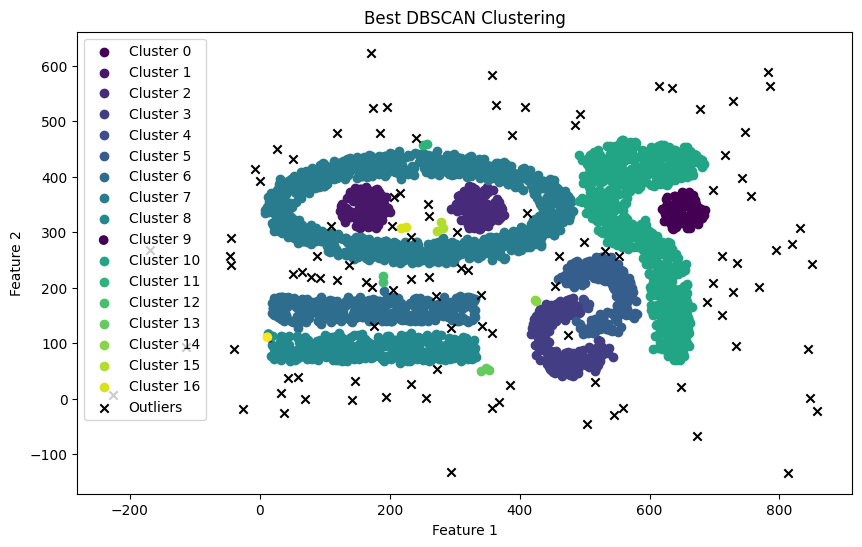

In [76]:
# Search for the best DBSCAN parameters
best_purity = 0
best_model = None
best_params = None

# Define parameter ranges for search
min_points_range = range(2, 21)
epsilon_range = np.linspace(0.5, 20, 50)
trials = 0

# Grid search over MinPoints and epsilon parameters
for min_points in min_points_range:
    for epsilon in epsilon_range:
        trials += 1
        if trials > 5000:
            break
        # Fit DBSCAN with current parameters
        dbscan = DBSCAN(eps=epsilon, min_samples=min_points)
        labels = dbscan.fit_predict(features)
        
        # Calculate purity and outlier percentage using the existing purity function
        purity_score, outlier_percentage = purity(labels, true_labels, outliers=True)
        
        # Count clusters (excluding outliers)
        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        # Check constraints
        if num_clusters >= 2 and num_clusters <= 18 and outlier_percentage <= 0.10:
            if purity_score > best_purity:
                best_purity = purity_score
                best_model = labels
                best_params = (min_points, epsilon, num_clusters, outlier_percentage)

print("num trials: {}".format(trials))

# Output best results if found
if best_model is not None:
    print("Best Clustering Result:")
    print(f"Purity: {best_purity:.4f}")
    print(f"MinPoints: {best_params[0]}, Epsilon: {best_params[1]:.2f}")
    print(f"Number of Clusters: {best_params[2]}")
    print(f"Outlier Percentage: {best_params[3]:.2%}")
else:
    print("No suitable clustering found within the constraints.")

# Visualization of the best clustering found
plt.figure(figsize=(10, 6))
unique_labels = set(best_model)
colors = plt.cm.get_cmap("viridis", len(unique_labels))

for label in unique_labels:
    if label == -1:  # Outliers
        color = 'k'
        marker = 'x'
    else:
        color = colors(label / len(unique_labels))
        marker = 'o'
    
    mask = (best_model == label)
    plt.scatter(features[mask].iloc[:, 0], features[mask].iloc[:, 1], c=color, marker=marker, label=f"Cluster {label}" if label != -1 else "Outliers")

plt.title("Best DBSCAN Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

#### Part C

Run  K-means  for  k=9  and  k=13  for  the  Complex9_gn8 dataset.  Report  the  cluster centroids,  the  SSE,  and  compute  the  purity  of  the  obtained  two  clustering  results. Visualize the two clustering clustering result. Finally, discuss the clusters what where found and compare them with those found with DBSCAN, and assess which clustering algorithm did a better job with the dataset. 

K-means Clustering with k=9:
Centroids:
 [[316.47879452 285.37385616]
 [506.13254167 326.23860648]
 [ 88.78288217 126.4835751 ]
 [119.20907163 346.73035078]
 [479.5977947  119.08658623]
 [619.25482461 181.1451124 ]
 [309.65129688 410.35014453]
 [251.75831383 124.51286139]
 [613.6955014  402.64985714]]
SSE: 16154595.22
Purity: 0.6699

K-means Clustering with k=13:
Centroids:
 [[358.39706504 291.95376016]
 [505.24624127 380.96280952]
 [ 64.68792438 126.52739347]
 [182.83070417 283.96545417]
 [481.6566532  116.50529596]
 [637.7228087  148.34227363]
 [329.66567873 401.90666063]
 [172.89988934 125.65825406]
 [636.52957303 396.25853558]
 [282.90284836 120.93960768]
 [ 54.82980083 345.55790816]
 [168.02359903 407.5229372 ]
 [565.72062848 257.47319195]]
SSE: 10627517.35
Purity: 0.6843



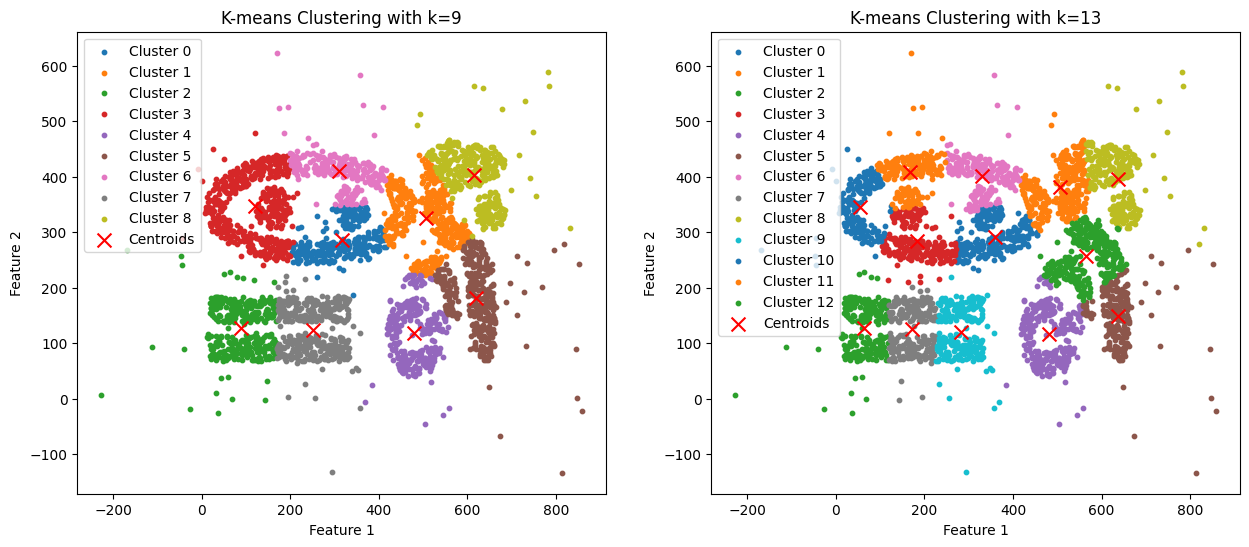

DBSCAN Results:
Purity: 0.9297
Outlier Percentage: 2.72%


In [77]:
# Function to calculate Sum of Squared Errors (SSE)
def calculate_sse(features, labels, centroids):
    sse = 0
    for i, centroid in enumerate(centroids):
        cluster_points = features[labels == i]
        sse += ((cluster_points - centroid) ** 2).sum()
    return sse

# Apply K-means with k=9
kmeans_9 = KMeans(n_clusters=9, random_state=42)
kmeans_9_labels = kmeans_9.fit_predict(features)
kmeans_9_centroids = kmeans_9.cluster_centers_
kmeans_9_sse = calculate_sse(features.values, kmeans_9_labels, kmeans_9_centroids)
kmeans_9_purity = purity(kmeans_9_labels, true_labels, outliers=False)

# Apply K-means with k=13
kmeans_13 = KMeans(n_clusters=13, random_state=42)
kmeans_13_labels = kmeans_13.fit_predict(features)
kmeans_13_centroids = kmeans_13.cluster_centers_
kmeans_13_sse = calculate_sse(features.values, kmeans_13_labels, kmeans_13_centroids)
kmeans_13_purity = purity(kmeans_13_labels, true_labels, outliers=False)

# Print results for both K-means clustering results
print("K-means Clustering with k=9:")
print("Centroids:\n", kmeans_9_centroids)
print(f"SSE: {kmeans_9_sse:.2f}")
print(f"Purity: {kmeans_9_purity:.4f}\n")

print("K-means Clustering with k=13:")
print("Centroids:\n", kmeans_13_centroids)
print(f"SSE: {kmeans_13_sse:.2f}")
print(f"Purity: {kmeans_13_purity:.4f}\n")

# Visualization of the K-means results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot k=9 clusters
unique_labels_9 = np.unique(kmeans_9_labels)
for label in unique_labels_9:
    mask = (kmeans_9_labels == label)
    ax1.scatter(features[mask].iloc[:, 0], features[mask].iloc[:, 1], label=f"Cluster {label}", s=10)
ax1.scatter(kmeans_9_centroids[:, 0], kmeans_9_centroids[:, 1], c='red', marker='x', s=100, label="Centroids")
ax1.set_title("K-means Clustering with k=9")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.legend()

# Plot k=13 clusters
unique_labels_13 = np.unique(kmeans_13_labels)
for label in unique_labels_13:
    mask = (kmeans_13_labels == label)
    ax2.scatter(features[mask].iloc[:, 0], features[mask].iloc[:, 1], label=f"Cluster {label}", s=10)
ax2.scatter(kmeans_13_centroids[:, 0], kmeans_13_centroids[:, 1], c='red', marker='x', s=100, label="Centroids")
ax2.set_title("K-means Clustering with k=13")
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")
ax2.legend()

plt.show()

# Optionally, you can apply DBSCAN to compare with K-means as discussed earlier
dbscan = DBSCAN(eps=11, min_samples=2)
dbscan_labels = dbscan.fit_predict(features)
dbscan_purity, dbscan_outlier_percentage = purity(dbscan_labels, true_labels, outliers=True)

print("DBSCAN Results:")
print(f"Purity: {dbscan_purity:.4f}")
print(f"Outlier Percentage: {dbscan_outlier_percentage:.2%}")